# Complaint Routing Model

#### by Jeffrey Strickland, Ph.D.
#### 12 August 2019

## Introduction

### Goal: route complaints to the proper researched team based on product groupings. 

The business unit receives complaintsin the form of free text and wants to route the complaints to the wants to route the complaints to one of seven different depaertments (product_group name in the daata parenthesis:.
	1. Bank account or service (bank_servie)
	2. Credit card (credit_card)
	3. Credit reporting (credict_reporting)
	4. Debt collection (debt_collection)
	5. Lines of loans (loan)
	6. Money Transfers (money_transfers)
	7. Mortgage (mortgange)

We have obtained a data set wiith 286,362 records that contains complaint text (text), a message identifier (complaint_id) and a verified correct complaint department product_group).

### Methodology

- We created three differnet classification models for comparison:

    - Naive Bayes
    - Classification Tree
    - Random Forest

- For of natural language processing (NLP) we chose the bag-of-words method.

## Load Required Packages

In [1]:
#Standard packages
import pandas as pd
import numpy as np
#import matplotlib
#from matplotlib import pyplot as plt

# Scikit Learn
from sklearn import preprocessing
from sklearn import tree
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold

#Natural Language Toolkit
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatiser = WordNetLemmatizer()

#String
import string


# Allow plots in Notebook
#%matplotlib inline

In [2]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

ModuleNotFoundError: No module named 'gensim'

## Optional Packages

In [4]:
#Plotly
import plotly
import plotly.graph_objects as go
import plotly.express as px
import chart_studio.plotly as py
import re
from sodapy import Socrata
from pprint import pprint

# Spacy for lemmatization
import spacy

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
# import seaborn as sns
#nltk.download('punkt')
#nltk.download('wordnet')

ModuleNotFoundError: No module named 'plotly'

### Loading (reading) the Dataset using Pandas
Our first step in the modeling process is to load the data. In this instance the data is contained in a CVS file that we will read into the Jupyter Notebook.

In [8]:
df = pd.read_csv("D:/Documents/Data/case_study_data_copy.csv")
# 80-20 splitting the dataset (80%->Training and 20%->Validation)
train, test = train_test_split(df, test_size=0.2)

### Data Exploration
The next several step we take are for exploring the complaint data, including listing the headings, viewing some records, and assessing the shape of the data frame.

In [9]:
list(df)

['complaint_id', 'product_group', 'text']

In [10]:
df.shape

(268380, 3)

### Data Exploration

In [11]:
df.head(5) # for showing a snapshot of the dataset

,complaint_id,product_group,text
0,2815595,bank_service,On check was debited from checking account and...
1,2217937,bank_service,opened a Bank of the the West account The acc...
2,2657456,bank_service,in nj opened a business account without autho...
3,1414106,bank_service,A hold was placed on saving account because in...
4,1999158,bank_service,Dear CFPBneed to send a major concerncomplaint...


## Prepare a Frequency Distribution

The next step consist of plotting the frequency of complaints for each product group and plotting the word counts

In [7]:
# Provides calculation of the shape of the data for each product group
bank_service_len = df[df['product_group'] == 'bank_service'].shape[0]
mortgage_len = df[df['product_group'] == 'mortgage'].shape[0]
credit_reporting_len = df[df['product_group'] == 'credit_reporting'].shape[0]
loan_len = df[df['product_group'] == 'loan'].shape[0]
credit_card_len = df[df['product_group'] == 'credit_card'].shape[0]
debt_collection_len = df[df['product_group'] == 'debt_collection'].shape[0]
money_transfers_len = df[df['product_group'] == 'money_transfers'].shape[0]

In [8]:
# Returns that complaint frequencies for each product group
credit_reporting_len, mortgage_len, bank_service_len, loan_len, credit_card_len, money_transfers_len

(81234, 40281, 20071, 31036, 29553, 4734)

## Plotting the Data

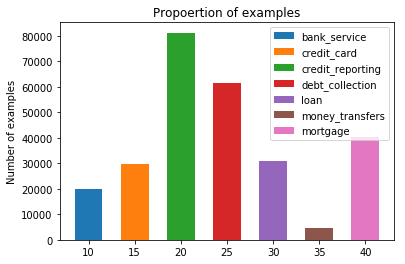

In [9]:
# Sets up the data for construct the frequency distribution (bar chart)
plt.bar(10,bank_service_len,3, label="bank_service")
plt.bar(15,credit_card_len,3, label="credit_card")
plt.bar(20,credit_reporting_len,3, label="credit_reporting")
plt.bar(25,debt_collection_len,3, label="debt_collection")
plt.bar(30,loan_len,3, label="loan")
plt.bar(35,money_transfers_len,3, label="money_transfers")
plt.bar(40,mortgage_len,3, label="mortgage")
plt.legend()
plt.ylabel('Number of samples')
plt.title('Proportion of samples')
plt.show()

## Store Product Group Data

The next step, and optional one, is to store the data for each product group into its own object for later use (potentially)

In [10]:
bks = df[df.product_group=="bank_service"]["text"].values
mtg = df[df.product_group=="mortgage"]["text"].values
crp = df[df.product_group=="credit_reporting"]["text"].values
ccd = df[df.product_group=="credit_card"]["text"].values
lon = df[df.product_group=="loan"]["text"].values
dct = df[df.product_group=="debt_collection"]["text"].values
mts = df[df.product_group=="money_transfers"]["text"].values

## Text Processing Steps:

1. Removal of Punctuation → All the punctuation marks are removed from all the text-snippets (instances or documents) from the dataset (corpus).
1. Lemmatisation → Inflected forms of a word are known as lemma. For example, (studying, studied) are inflected forms or lemma of the word study which is the root word. So, the lemma of a word are grouped under the single root word. This is done to make the vocabulary of words in the corpus contain distinct words only.
1. Removal of Stopwords → Stop-words are usually articles (a, an, the), prepositions (in, on, under, …) and other frequently occurring words that do not provide any key or necessary information. They are removed from all the text-snippets present in the dataset (corpus).

In [11]:
# Defining a module for Text Processing
def text_process(tex):
    
# 1. Removal of Punctuation Marks 
    nopunct=[char for char in tex if char not in string.punctuation]
    nopunct=''.join(nopunct)

# 2. Lemmatisation 
    a=''
    i=0
    for i in range(len(nopunct.split())):
        b=lemmatiser.lemmatize(nopunct.split()[i], pos="v")
        a=a+b+' '

# 3. Removal of Stopwords
    return [word for word in a.split() if word.lower() not 
            in stopwords.words('english')]

## Label Encoding of Classes:

- As this is a classification problem, here classes are the 7 product groups as mentioned. In our dataset, the labels are non-numeric (bank_services, credit_card, credit_reporting, debt_collection, loan, money_transfers, and mortgage). 
- These are label encoded to make them numeric, starting from 0 depicting each label in the alphabetic order i.e., (0 → bank_services, 1 → credit_card, 2 → credit_reporting, 3 → debt_collection, 4 → loan, 5 → money_transfers, and 5 → mortgage).

In [12]:
# Importing necessary libraries
from sklearn.preprocessing import LabelEncoder

y = df['product_group']
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)

## Word Cloud Visualization:

We developed the word clouds as follows:

- Product groups have their own unique words and phrases in as well as some common ones
- visualization of the mostly-used words to the least-used words for the product groups can be done
- Seven text snippets each belonging to the 7 product groups respectively can render a Word Cloud

In [13]:
# Importing necessary libraries
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt

X = df['text']

wordcloud0 = WordCloud().generate(X[0]) # for bank_service
wordcloud1 = WordCloud().generate(X[1]) # for credit_card
wordcloud2 = WordCloud().generate(X[2]) # for credit_reporting 
wordcloud3 = WordCloud().generate(X[3]) # for debt_collection 
wordcloud4 = WordCloud().generate(X[4]) # for loan
wordcloud5 = WordCloud().generate(X[5]) # for money_transfers
wordcloud6 = WordCloud().generate(X[6]) # for mortgage


bank_service


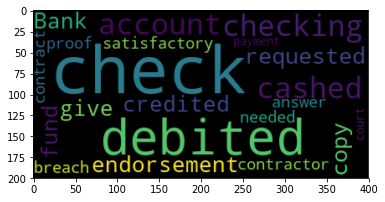

In [14]:
#print(X[0])
print(df['product_group'][0])
plt.imshow(wordcloud0, interpolation='bilinear')
plt.show()



credit_card


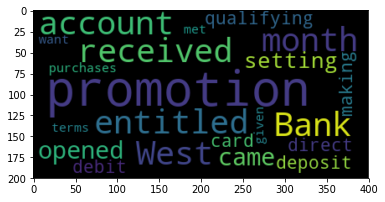

In [15]:
#print(X[22100])
print(df['product_group'][22100])
plt.imshow(wordcloud1, interpolation='bilinear')
plt.show()



credit_card


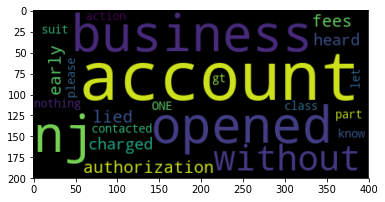

In [16]:
#print(X[42000])
print(df['product_group'][42000])
plt.imshow(wordcloud2, interpolation='bilinear')
plt.show()



debt_collection


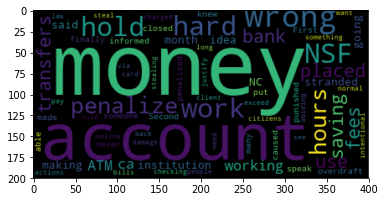

In [17]:
#print(X[152100])
print(df['product_group'][152100])
plt.imshow(wordcloud3, interpolation='bilinear')
plt.show()



loan


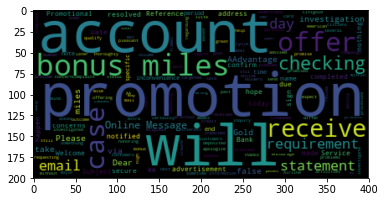

In [18]:
#print(X[199100])
print(df['product_group'][199100])
plt.imshow(wordcloud4, interpolation='bilinear')
plt.show()



money_transfers


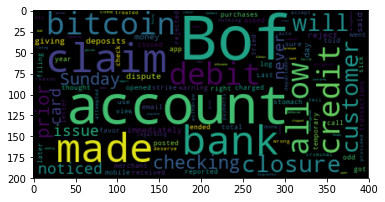

In [19]:
#print(X[227100])
print(df['product_group'][227100])
plt.imshow(wordcloud5, interpolation='bilinear')
plt.show()



mortgage


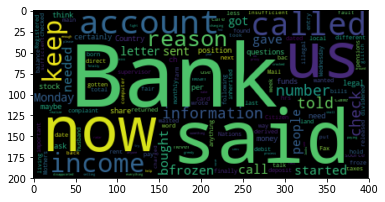

In [20]:
#print(X[237100])
print(df['product_group'][237100])
plt.imshow(wordcloud6, interpolation='bilinear')
plt.show()

## Create Train and Test Sets

In [21]:
# Importing necessary libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# 80-20 splitting the dataset (80%->Training and 20%->Validation)
X_train, X_test, y_train, y_test = train_test_split(X, y
                                  ,test_size=0.2, random_state=1234)

## Feature Engineering using Bag-of-Words:

- Machine Learning Algorithms work only on numeric data. 
- But here, data is present in the form of text only. 
- For that, by some means, textual data needs to be transformed into numeric form. 
- One such approach of doing this, is Feature Engineering. 
- In this approach, numeric features are extracted or engineered from textual data. 
- There are many Feature Engineering Techniques in existence. 
- In this problem, Bag-of-Words Technique of Feature Engineering has been used.

### Bag-of-Words (BOW):

- With Bag-of-Words a vocabulary of words present in the corpus is maintained. 
- These words serve as features for each instance or document (each complaint). 
- Against each word as feature, its frequency in the current document (complaint) is considered. 
- In this way word features are engineered or extracted from the textual data or corpus.

### BOW Preparation

In [23]:
# defining the bag-of-words transformer on the text-processed corpus 
# i.e., text_process() declared in II is executed...
bow_transformer=CountVectorizer(analyzer=text_process).fit(X_train)

In [24]:
# transforming into Bag-of-Words and hence textual data to numeric..
text_bow_train=bow_transformer.transform(X_train)#ONLY TRAINING DATA

In [25]:
# transforming into Bag-of-Words and hence textual data to numeric..
text_bow_test=bow_transformer.transform(X_test)#TEST DATA

## Training the Multinomial Naive Bayes Model:

Multinomial Naive Bayes Algorithm (Classifier) has been used as the Classification Machine Learning Algorithm [1].

In [26]:
# Importing necessary libraries
from sklearn.naive_bayes import MultinomialNB

# instantiating the model with Multinomial Naive Bayes..
model = MultinomialNB()

# training the model...
model = model.fit(text_bow_train, y_train)

### Model Performance Analysis:

#### Training Accuracy

In [27]:
bayes_score = model.score(text_bow_train, y_train)
bayes_score

0.8244420225054028

#### Validation Accuracy

In [28]:
bayes_val_score = model.score(text_bow_test, y_test)
bayes_val_score

0.8099336761308592

The cross-validation score is very close to the model score, 80.99 versus 82.44. The naive Bayes model is a good fit of the data and will produce good predictions.


### Precision, Recall and F1–Score

In [29]:
# Importing necessary libraries
from sklearn.metrics import classification_report
 
# getting the predictions of the Validation Set...
bayes_preds = model.predict(text_bow_test)

# getting the Precision, Recall, F1-Score
print(classification_report(y_test,bayes_preds))

             precision    recall  f1-score   support

          0       0.75      0.82      0.78      3923
          1       0.73      0.76      0.74      5956
          2       0.82      0.82      0.82     16325
          3       0.83      0.77      0.80     12277
          4       0.73      0.79      0.76      6214
          5       0.90      0.59      0.71       933
          6       0.90      0.92      0.91      8048

avg / total       0.81      0.81      0.81     53676



### Naive Bayes Predictions

In [30]:
bayes_preds[0:10]

array([2, 1, 2, 1, 6, 2, 0, 3, 2, 2], dtype=int64)

In [31]:
model.predict_proba(text_bow_test)

array([[8.52135807e-55, 9.69725328e-45, 1.00000000e+00, ...,
        6.20090941e-59, 9.85512180e-83, 6.81545736e-58],
       [1.69421414e-06, 9.97802971e-01, 2.19522849e-03, ...,
        3.07868517e-11, 1.41445517e-11, 3.44369895e-13],
       [1.76627978e-23, 1.28994027e-21, 1.00000000e+00, ...,
        1.33875339e-19, 1.10668343e-29, 5.55947237e-27],
       ...,
       [1.01351524e-19, 2.67304225e-13, 9.85595916e-06, ...,
        3.05085648e-12, 1.25329500e-25, 4.13797077e-16],
       [8.04595925e-04, 2.19579648e-03, 9.13140087e-01, ...,
        9.09204106e-03, 5.92172507e-07, 3.81862527e-03],
       [1.18189522e-12, 9.94089693e-11, 1.16008194e-11, ...,
        1.00441177e-07, 4.53937837e-18, 3.66174694e-10]])

### Confusion Matrix

In [32]:
from sklearn import svm, datasets
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 3213   355   129    55    51    32    88]
 [  395  4556   578   224   155    16    32]
 [  106   700 13459  1055   708     3   294]
 [   94   351  1494  9443   666     4   225]
 [  115   181   442   448  4879     3   146]
 [  270    71     6    16    15   546     9]
 [   87    67   227   106   183     0  7378]]


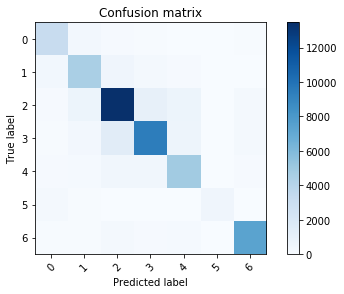

In [33]:
# Compute confusion matrix
cm = confusion_matrix(y_test,bayes_preds)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1,2,3,4,5,6])

Normalized confusion matrix
[[8.19e-01 9.05e-02 3.29e-02 1.40e-02 1.30e-02 8.16e-03 2.24e-02]
 [6.63e-02 7.65e-01 9.70e-02 3.76e-02 2.60e-02 2.69e-03 5.37e-03]
 [6.49e-03 4.29e-02 8.24e-01 6.46e-02 4.34e-02 1.84e-04 1.80e-02]
 [7.66e-03 2.86e-02 1.22e-01 7.69e-01 5.42e-02 3.26e-04 1.83e-02]
 [1.85e-02 2.91e-02 7.11e-02 7.21e-02 7.85e-01 4.83e-04 2.35e-02]
 [2.89e-01 7.61e-02 6.43e-03 1.71e-02 1.61e-02 5.85e-01 9.65e-03]
 [1.08e-02 8.33e-03 2.82e-02 1.32e-02 2.27e-02 0.00e+00 9.17e-01]]


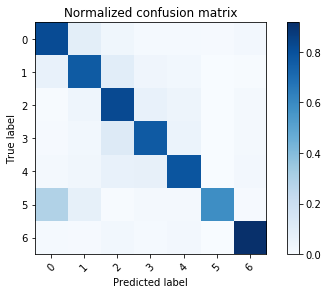

In [34]:
# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, classes=[0,1,2,3,4,5,6],title='Normalized confusion matrix')
plt.show()

# Training the Classification Tree Model

In [55]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(text_bow_train, y_train)

In [153]:
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Classification Tree Scores

In [56]:
from sklearn import tree

In [57]:
tree_score = clf.score(text_bow_train, y_train)
tree_score

0.9991336910350995

In [58]:
tree_val_score = clf.score(text_bow_test, y_test)
tree_val_score

0.7594269319621433

The cross-validation score is much lower than the model score, 75.83 versus 99.91. The classificaton tree model is over-fitting the data and will produce numerous false positives.


### Classification Tree Predictions

In [59]:
tree_preds = clf.predict(text_bow_test)
tree_preds[0:10]

array([3, 1, 2, 1, 6, 2, 2, 3, 5, 2], dtype=int64)

In [60]:
clf.predict_proba(text_bow_test)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Tree Summary

According to the Performance Analysis, we can conclude that this model may be overfitting the data, given th significant difference wetween train and test scores. 
- Train: 99.91% 
- Test: 75.94%

# Training the Random Forest Model

In [154]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

In [155]:
rf = RandomForestClassifier(n_estimators=100) # initialize
rf.fit(text_bow_train, y_train) # fit the data to the algorithm

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Random Forest Model Scores

In [219]:
forest_score = rf.score(text_bow_train, y_train)
forest_score

0.9991336910350995

In [218]:
forest_val_score = rf.score(text_bow_test, y_test)
forest_val_score

0.8245025709814442

In [174]:
rf.get_params(rf.fit)

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### Random Forest Predictions

In [204]:
forest_preds = rf.predict(text_bow_test)
forest_preds[0:10]

array([2, 1, 2, 1, 6, 2, 2, 3, 2, 2], dtype=int64)

In [176]:
rf.predict_proba(text_bow_test)[0:10]

array([[0.02, 0.08, 0.47, 0.28, 0.02, 0.01, 0.12],
       [0.07, 0.32, 0.3 , 0.2 , 0.02, 0.05, 0.04],
       [0.  , 0.02, 0.85, 0.06, 0.05, 0.  , 0.02],
       [0.08, 0.45, 0.12, 0.17, 0.09, 0.02, 0.07],
       [0.05, 0.04, 0.11, 0.08, 0.1 , 0.01, 0.61],
       [0.  , 0.01, 0.95, 0.01, 0.  , 0.01, 0.02],
       [0.03, 0.14, 0.56, 0.14, 0.03, 0.02, 0.08],
       [0.  , 0.11, 0.25, 0.52, 0.09, 0.  , 0.03],
       [0.01, 0.08, 0.53, 0.23, 0.04, 0.  , 0.11],
       [0.05, 0.1 , 0.64, 0.08, 0.03, 0.02, 0.08]])

### Random Forest Summary

The random forest model is probably over-fitting the data and will produce numerous false positives. The cross-validation score is much lower than the model score. 
- Train: 99.91. 
- Test: 82.45  

# Model Comparisons

In [208]:
bayes_preds[0:20], tree_preds[0:20], forest_preds[0:20]

(array([2, 1, 2, 1, 6, 2, 0, 3, 2, 2, 1, 3, 2, 4, 1, 4, 2, 6, 6, 4],
       dtype=int64),
 array([2, 0, 2, 1, 6, 2, 2, 3, 0, 2, 0, 2, 2, 4, 1, 4, 2, 3, 6, 4],
       dtype=int64),
 array([2, 1, 2, 1, 6, 2, 2, 3, 2, 2, 0, 2, 2, 4, 1, 4, 2, 6, 6, 4],
       dtype=int64))

In [224]:
bayes_score, bayes_val_score, tree_score, tree_val_score, forest_score, forest_val_score

(0.8244420225054028,
 0.8099336761308592,
 0.9991336910350995,
 0.7583463745435577,
 0.9991336910350995,
 0.8245025709814442)

# Conclusion

- The Classification and Rando Forest models will have a tendency to over-predict. 
- While the Naive Bayes was trained having a lower performnce score (82,44),it will have more accurate predictions. 
- If we had an out-of-time sample, we could perform better validations on the three models. 
- In the mean time, we recommend the Naive Bayes Classification MOdel. 

## Backup Material

#### Legend
- 0 = bank service
- 1 = credit card
- 2 = credit reporting
- 3 = debt collection
- 4 = loan
- 5 = money transfers
- 6 = mortgage

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
comp=bow_transformer.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])
print(model.predict(comp))

[3]


In [36]:
comp2=bow_transformer.transform(["someone stole my credit card and used it at walmart. I received a credit card alert on my mastercard."])
print(model.predict(comp2))

[1]


In [37]:
comp3=bow_transformer.transform(["I am trying tos get a second morgage. the rate on my original mortgage is high."])
print(model.predict(comp3))

[6]


In [38]:
comp3=bow_transformer.transform(["I wanted to get a loan to purchase a new car, but they said my credit score was too low due to other outstanding loans. I don't see what the big deal is with having other loans."])
print(model.predict(comp3))

[4]


## Multi-layer Perceptron Classifier

In [47]:
from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 4), random_state=1)
mlpc.fit(text_bow_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 4), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

### MLPClassifier Scores
#### *Training Accuracy*

In [48]:
MLPC_score = mlpc.score(text_bow_train, y_train)
MLPC_score

0.8821121171473284

#### Validation Accuracy

In [49]:
MLPC_val_score = mlpc.score(text_bow_test, y_test)
MLPC_val_score

0.818708547581787

The cross-validation score is very close to the model score, 88.21 versus 81.87. The naive Bayes model is a good fit of the data and will produce good predictions.

## Multi-class Support Vector Machine

In [52]:
from sklearn import svm
svm_class = svm.LinearSVC()
svm_class.fit(text_bow_train, y_train) 

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

### SVM Scores
#### *Training Accuracy*

In [53]:
SVM_score = svm_class.score(text_bow_train, y_train)
SVM_score

0.9432381324986959

#### *Validation Accuracy*

In [54]:
SVM_val_score = svm_class.score(text_bow_test, y_test)
SVM_val_score

0.8125605484760414

The cross-validation score is very close to the model score, 94.32 versus 81.25. The naive Bayes model is a good fit of the data and will produce good predictions.
